#### Imports and functions

In [2]:
from keras.datasets           import mnist
from keras.utils              import to_categorical
from keras.models             import Sequential
from keras.layers             import Dense, Conv2D, Flatten, GlobalAveragePooling2D
from sklearn.model_selection  import train_test_split
from sklearn.metrics          import accuracy_score, confusion_matrix
from sklearn.svm              import LinearSVC
from datetime                 import datetime

import matplotlib.pyplot as plt
import tensorflow        as tf
import numpy             as np

import requests, zipfile, io, itertools

In [3]:
def preprocess_images(images, scale=True, standardize=True):
  if scale == True:
    images = np.array([scale_image(image, 24, 24) for image in images])
  
  if standardize == True:
    images = (images - images.mean(axis=(0,1,2), keepdims=True)) / images.std(axis=(0,1,2), keepdims=True)

  return images

def scale_image(im, nR, nC):
  nR0 = len(im)     # source number of rows 
  nC0 = len(im[0])  # source number of columns 
  return [[ im[int(nR0 * r / nR)][int(nC0 * c / nC)]  
             for c in range(nC)] for r in range(nR)]

def print_infos(predictions, y_test):
  
  for i in range(len(predictions)):
    max = np.max(predictions[i])
    predictions[i] = [0 if value != max else 1 for value in predictions[i] ]

  print("Accuracy: " + str(accuracy_score(y_test, predictions)))

  cm = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
  plot_confusion_matrix(cm, ["AC", "AD", "H"], normalize=True, figsize=(4, 4))

def plot_confusion_matrix(cm,
                          classes,
                          normalize=True,
                          figsize=(7, 7),
                          title='Confusion matrix',
                          cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        print('Confusion matrix without normalization')
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 fontsize=20,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)

def extract_features(model, layer_index, data):
  feature_extractor = tf.keras.Model(model.inputs, model.layers[layer_index].output)
  return feature_extractor.predict(data)

### 1. Training from scratch a VGG16

In [4]:
r = requests.get("https://github.com/FrPo/crc_3_classi_64x64/blob/master/crc_3_classi.zip?raw=true") 

zip_file = zipfile.ZipFile(io.BytesIO(r.content))
zip_file.extractall()

X_train = np.load("/content/train_X.npy")
Y_train = np.load("/content/train_Y.npy")

x_test  = np.load("/content/test_X.npy")
y_test  = np.load("/content/test_Y.npy")

# Splitting dataset
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2)

# Preprocessing images
x_train = preprocess_images(x_train, scale=False)
x_val   = preprocess_images(x_val,   scale=False)
x_test  = preprocess_images(x_test,  scale=False)

# One hot encoding
y_train = to_categorical(y_train)
y_val   = to_categorical(y_val)
y_test  = to_categorical(y_test)

In [ ]:
backbone = tf.keras.applications.vgg16.VGG16(weights=None, include_top=False, input_shape=(32, 32, 3))
model    = Sequential()

GlobalAveragePooling2D_1 = GlobalAveragePooling2D()
Dense_2                  = Dense(1024, activation='relu')
Dense_3                  = Dense(512,  activation='relu')
Dense_4                  = Dense(3,    activation='softmax')

model.add(backbone)
model.add(GlobalAveragePooling2D_1)
model.add(Dense_2)
model.add(Dense_3)
model.add(Dense_4)

model.compile(optimizer = tf.keras.optimizers.Adam(0.0001), loss = "categorical_crossentropy", metrics = [ "accuracy" ] )

logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs, histogram_freq = 1, profile_batch = '20, 30')

model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30, callbacks = [tboard_callback])

Epoch 1/30
225/225 [==============================] - 9s 39ms/step - loss: 0.5888 - accuracy: 0.7056 - val_loss: 0.4315 - val_accuracy: 0.8267
Epoch 2/30
225/225 [==============================] - 8s 36ms/step - loss: 0.3244 - accuracy: 0.8753 - val_loss: 0.2827 - val_accuracy: 0.8944
Epoch 3/30
225/225 [==============================] - 8s 36ms/step - loss: 0.2679 - accuracy: 0.9047 - val_loss: 0.2006 - val_accuracy: 0.9350
Epoch 4/30
225/225 [==============================] - 8s 36ms/step - loss: 0.2026 - accuracy: 0.9307 - val_loss: 0.1848 - val_accuracy: 0.9339
Epoch 5/30
225/225 [==============================] - 8s 36ms/step - loss: 0.1342 - accuracy: 0.9532 - val_loss: 0.1876 - val_accuracy: 0.9256
Epoch 6/30
225/225 [==============================] - 8s 36ms/step - loss: 0.0946 - accuracy: 0.9674 - val_loss: 0.0715 - val_accuracy: 0.9761
Epoch 7/30
225/225 [==============================] - 8s 36ms/step - loss: 0.1007 - accuracy: 0.9685 - val_loss: 0.1442 - val_accuracy: 0.9522

Accuracy: 0.8988888888888888


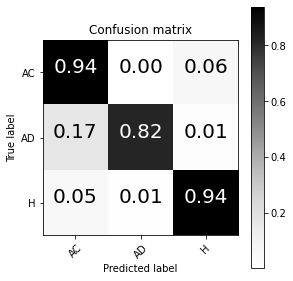

In [ ]:
predictions = model.predict(x_test)

print_infos(predictions, y_test)

### 2. Load pretrained VGG16 model

In [ ]:
backbone = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))
model    = Sequential()

GlobalAveragePooling2D_1 = GlobalAveragePooling2D()
Dense_2                  = Dense(1024, activation='relu')
Dense_3                  = Dense(512,  activation='relu')
Dense_4                  = Dense(3,    activation='softmax')

model.add(backbone)
model.add(GlobalAveragePooling2D_1)
model.add(Dense_2)
model.add(Dense_3)
model.add(Dense_4)

model.compile(optimizer = tf.keras.optimizers.Adam(0.0001), loss = "categorical_crossentropy", metrics = [ "accuracy" ] )

logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs, histogram_freq = 1, profile_batch = '20, 30')

model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30, callbacks = [tboard_callback])

Epoch 1/10
 29/225 [==>...........................] - ETA: 5s - loss: 0.4936 - accuracy: 0.8028WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
225/225 [==============================] - 8s 36ms/step - loss: 0.2360 - accuracy: 0.9140 - val_loss: 0.0859 - val_accuracy: 0.9667
Epoch 2/10
225/225 [==============================] - 8s 34ms/step - loss: 0.0816 - accuracy: 0.9725 - val_loss: 0.1231 - val_accuracy: 0.9556
Epoch 3/10
225/225 [==============================] - 8s 34ms/step - loss: 0.0682 - accuracy: 0.9740 - val_loss: 0.1025 - val_accuracy: 0.9650
Epoch 4/10
225/225 [==============================] - 8s 34ms/step - loss: 0.0489 - accuracy: 0.9818 - val_loss: 0.0980 - val_accuracy: 0.9633
Epoch 5/10
225/225 [==============================] - 8s 34ms/step

Accuracy: 0.8913333333333333


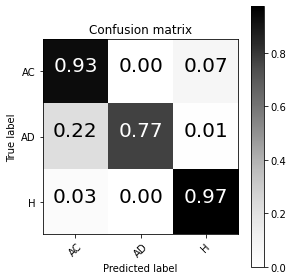

In [ ]:
predictions = model.predict(x_test)

print_infos(predictions, y_test)

### 3. Features extraction - Train an SVC using CNN features

In [ ]:
for layer_index in range(3, len(backbone.layers)):

  features_train_deep = extract_features(
      model       = backbone, 
      layer_index = layer_index, 
      data        = x_train
      )

  features_test_deep = extract_features(
      model       = backbone, 
      layer_index = layer_index, 
      data        = x_test
      )

  # Extract features shape
  shape = features_train_deep.shape

  # Get shapes of the flatten array (moltiplication of the all previous dimensions)
  new_shape      = (shape[0], shape[1]*shape[2]*shape[3])
  features_train = np.reshape(features_train_deep, new_shape)

  # Extract features shape
  shape = features_test_deep.shape

  # Get shapes of the flatten array (moltiplication of the all previous dimensions)
  new_shape     = (shape[0], shape[1]*shape[2]*shape[3])
  features_test = np.reshape(features_test_deep, new_shape)

  # Train a LinearSVC and get results on test set
  svm = LinearSVC(max_iter=30000000)
  svm.fit(features_train, y_train.argmax(axis=1))
  predictions = svm.predict(features_test)
  print("Layer index: " + str(layer_index) + ". Accuracy: " + str(accuracy_score(y_test.argmax(axis=1), predictions)))

Layer index: 3. Accuracy: 0.7597777777777778
Layer index: 4. Accuracy: 0.8148888888888889
Layer index: 5. Accuracy: 0.8666666666666667
Layer index: 6. Accuracy: 0.8895555555555555
Layer index: 7. Accuracy: 0.9
Layer index: 8. Accuracy: 0.9008888888888889
Layer index: 9. Accuracy: 0.9004444444444445
Layer index: 10. Accuracy: 0.9113333333333333
Layer index: 11. Accuracy: 0.9144444444444444
Layer index: 12. Accuracy: 0.9166666666666666
Layer index: 13. Accuracy: 0.9164444444444444
Layer index: 14. Accuracy: 0.9171111111111111
Layer index: 15. Accuracy: 0.9148888888888889
Layer index: 16. Accuracy: 0.9206666666666666
Layer index: 17. Accuracy: 0.9213333333333333
Layer index: 18. Accuracy: 0.9213333333333333


### 4. VGG16 Fine Tuning

In [5]:
start_freezing_from_layer = 3

backbone = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))

# Allow to the last convolutional and the classification stages to train
for layer in backbone.layers:
  if layer.name == 'block5_conv1':
    break
  layer.trainable = False
  print('Layer ' + layer.name + ' frozen.')

model    = Sequential()

GlobalAveragePooling2D_1 = GlobalAveragePooling2D()
Dense_2                  = Dense(1024, activation='relu')
Dense_3                  = Dense(512,  activation='relu')
Dense_4                  = Dense(3,    activation='softmax')

model.add(backbone)
model.add(GlobalAveragePooling2D_1)
model.add(Dense_2)
model.add(Dense_3)
model.add(Dense_4)

model.compile(optimizer = tf.keras.optimizers.Adam(0.001), loss = "categorical_crossentropy", metrics = [ "accuracy" ] )

logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs, histogram_freq = 1, profile_batch = '20, 30')

model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=15, callbacks = [tboard_callback])

58892288/58889256 [==============================] - 0s 0us/step
Layer input_1 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Epoch 1/15
 28/225 [==>...........................] - ETA: 3s - loss: 0.6587 - accuracy: 0.7388WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
225/225 [==============================] - 6s 25ms/step - loss: 0.2707 - accuracy: 0.9040 - val_loss: 0.1680 - val_accuracy: 0.9528
Epoch 2/15
225/225 [==============

Accuracy: 0.9222222222222223


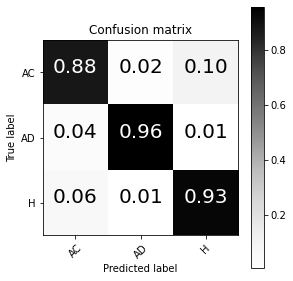

In [6]:
predictions = model.predict(x_test)

print_infos(predictions, y_test)